# Interactive Recipe & Kitchen Management Assistant


## Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.


## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Data analysis and visualization libraries
!pip install -q --no-input --no-color --disable-pip-version-check pandas matplotlib seaborn 

# Install dependencies as needed:
!pip install -q --no-input --no-color --disable-pip-version-check kagglehub[pandas-datasets]
# Setup additional Google API libraries
!pip install -q --no-input --no-color --disable-pip-version-check google-generativeai  # For Gemini API
!pip install -q --no-input --no-color --disable-pip-version-check google-cloud-speech  # For Speech-to-Text
!pip install -q --no-input --no-color --disable-pip-version-check soundfile
!pip install -q --no-input --no-color --disable-pip-version-check pydub  # For audio file handling
!pip install -q --no-input --no-color --disable-pip-version-check ipywidgets
!pip install -q --no-input --no-color --disable-pip-version-check openai


# Remove unused packages and install specific Google API version
!pip uninstall -qqy --no-input jupyterlab > /dev/null  # Remove unused packages from Kaggle's base image that conflict
!pip install -U -q --no-input --no-color --disable-pip-version-check "google-genai==1.7.0"

print("All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.5 MB/s eta 0:00:00
All dependencies installed successfully!


## Import Libraries

Now let's import the libraries we'll need for this step.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
from pathlib import Path
import datetime
import random
import warnings
from openai import OpenAI
import io
import tempfile

import ipywidgets as widgets
from IPython.display import Audio, clear_output, display, HTML, clear_output, Markdown
from typing import Dict, List, Optional, Tuple, Any


import sqlite3
import chromadb
from chromadb.utils import embedding_functions

# Set warnings filter
warnings.filterwarnings('ignore')

# Audio processing libraries with error handling
try:
    import soundfile as sf
    import sounddevice as sd
    from IPython.display import Audio, display
    AUDIO_LIBRARIES_AVAILABLE = True
    print("Audio libraries imported successfully!")
except (ImportError, OSError) as e:
    print(f"Warning: Audio libraries could not be imported: {e}")

# Google Cloud Speech-to-Text (with error handling)
try:
    from google.cloud import speech
    GOOGLE_SPEECH_AVAILABLE = True
    print("Google Cloud Speech-to-Text is imported successfully!")
except ImportError:
    GOOGLE_SPEECH_AVAILABLE = False
    print("Google Cloud Speech-to-Text not available. Will use simulation for speech recognition.")

# Google Gemini API for natural language understanding
from google import genai
from google.genai import types
from google.api_core import retry

# Set up a retry helper. This allows you to "Run all" without worrying about per-minute quota.
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")
genai.__version__

Google Cloud Speech-to-Text is imported successfully!
Environment setup complete!


'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`, `GOOGLE_APPLICATION_CREDENTIALS`, `OPENAI_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

Furthermore, for the Google Cloud Client Libraries (like the google-cloud-speech Python library you're using), you generally cannot authenticate using only an API Key. 🚫🔑, So you need to provide and import Service Account Credentials (JSON Key File).

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
OPENAI_API_KEY = UserSecretsClient().get_secret("OPENAI_API_KEY")
SecretValueJson = UserSecretsClient().get_secret("GOOGLE_APPLICATION_CREDENTIALS") # Use the label you gave the secret



## Data Loading

### Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below


We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

loading both the vectorized and raw data and nutritional breakdown dataset that will be used in subsequent steps, particularly for the few-shot prompting recipe customization implementation.

In [5]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
    interactions_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
    pp_recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv')
    pp_users_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv')
    nutrition_df = pd.read_csv('/kaggle/input/nutritional-breakdown-of-foods/cleaned_nutrition_dataset.csv')

    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    print(f"Successfully loaded nutritional dataset with {len(nutrition_df)} records")
    print(f"Successfully loaded vectorized recipe data with {len(pp_recipes_df)} records")
    print(f"Successfully loaded vectorized user data with {len(pp_users_df)} records")
    
    
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'persian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
      
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")



Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions
Successfully loaded nutritional dataset with 3454 records
Successfully loaded vectorized recipe data with 178265 records
Successfully loaded vectorized user data with 25076 records
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [6]:

# Basic dataset information
print("Raw Datasets information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\recipes_df columns:")
print(recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of interactions: {len(interactions_df)}")
print("\ninteractions_df columns:")
print(interactions_df.columns.tolist())
print(15 * "-")
print(f"Number of nutritions: {len(nutrition_df)}")
print("\nnutrition_df columns:")
print(nutrition_df.columns.tolist())
print(15 * "-")
print("Vectorized Datasets information:")

print(f"Number of pp_recipes: {len(pp_recipes_df)}")
print("\npp_recipes columns:")
print(pp_recipes_df.columns.tolist())
print(15 * "-")
print(f"Number of pp_users: {len(pp_users_df)}")
print("\npp_users columns:")
print(pp_users_df.columns.tolist())
print(15 * "-")

Raw Datasets information:
Number of recipes: 231637
ecipes_df columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type']
---------------
Number of interactions: 1132367

interactions_df columns:
['user_id', 'recipe_id', 'date', 'rating', 'review']
---------------
Number of nutritions: 3454

nutrition_df columns:
['Vitamin C', 'Vitamin B11', 'Sodium', 'Calcium', 'Carbohydrates', 'food', 'Iron', 'Caloric Value', 'Sugars', 'Dietary Fiber', 'Fat', 'Protein', 'food_normalized']
---------------
Vectorized Datasets information:
Number of pp_recipes: 178265

pp_recipes columns:
['id', 'i', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'techniques', 'calorie_level', 'ingredient_ids']
---------------
Number of pp_users: 25076

pp_users columns:
['u', 'techniques', 'items', 'n_items', 'ratings', 'n_ratings']
---------------


In [7]:

# Function to analyze dataframe properties
def analyze_dataframe(df, df_name):
    print(f"\n{'-' * 30}")
    print(f"Analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # Check data types
    print("\nData types:")
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")
    
    # Check missing values
    print("\nMissing values per column:")
    missing_values = df.isnull().sum()
    for col, missing in zip(missing_values.index, missing_values.values):
        if missing > 0:
            print(f"{col}: {missing} missing values ({missing/len(df):.2%})")
    
    # Summary statistics for numeric columns
    print("\nNumeric columns summary:")
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if numeric_cols:
        # Show basic stats for numeric columns only
        print(df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
    else:
        print("No numeric columns found")

# Analyze all dataframes
print("\n=== DATA ANALYSIS FOR ALL DATAFRAMES ===")
analyze_dataframe(recipes_df, "Recipes")
analyze_dataframe(interactions_df, "Interactions")
analyze_dataframe(nutrition_df, "Nutrition")
analyze_dataframe(pp_recipes_df, "Preprocessed Recipes")
analyze_dataframe(pp_users_df, "Preprocessed Users")





=== DATA ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Analysis for Recipes:
------------------------------

Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)

Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01

------------------------------
Analysis for Interactions:
------------------------------

Data types:
user_id: int64
recipe_id: int64
date: object
rating: int6

In [8]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                                                        name      id  minutes  \
98169   grilled asparagus salad with lemon chive vinaigrette  484726       27   
164368                    pot roast with bourbon maple glaze  118127      200   
59521                                           cowboy bread  442310       45   

        contributor_id   submitted  \
98169          1072593  2012-08-01   
164368           47907  2005-04-20   
59521          1733901  2010-11-18   

                                                                                                       tags  \
98169   [30-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, salads, vegeta...   
164368  [time-to-make, course, main-ingredient, preparation, occasion, main-dish, beef, vegetables, easy...   
59521   [60-minutes-or-less, time-to-make, course, preparation, occasion, breads, potluck, picnic, coffe...   

                                              nutrition  n_step

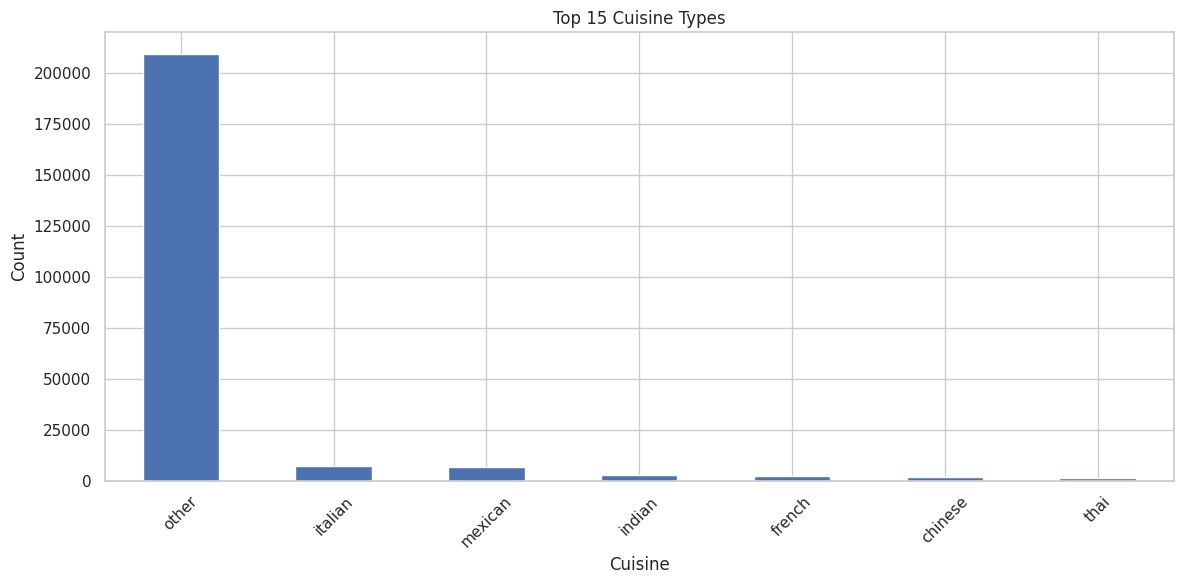

In [10]:
# Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [25]:
# # Distribution of cooking time - use smaller bins
# if 'cooking_time' in recipes_df.columns:
#     plt.figure(figsize=(10, 6))
#     # Use log scale for better visualization if the range is large
#     if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
#         sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
#         plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
#     else:
#         sns.histplot(recipes_df['cooking_time'], bins=20)
#         plt.title('Distribution of Cooking Time (minutes)')
#     plt.xlabel('Cooking Time (minutes)')
#     plt.ylabel('Count')
#     plt.tight_layout()
#     plt.show()

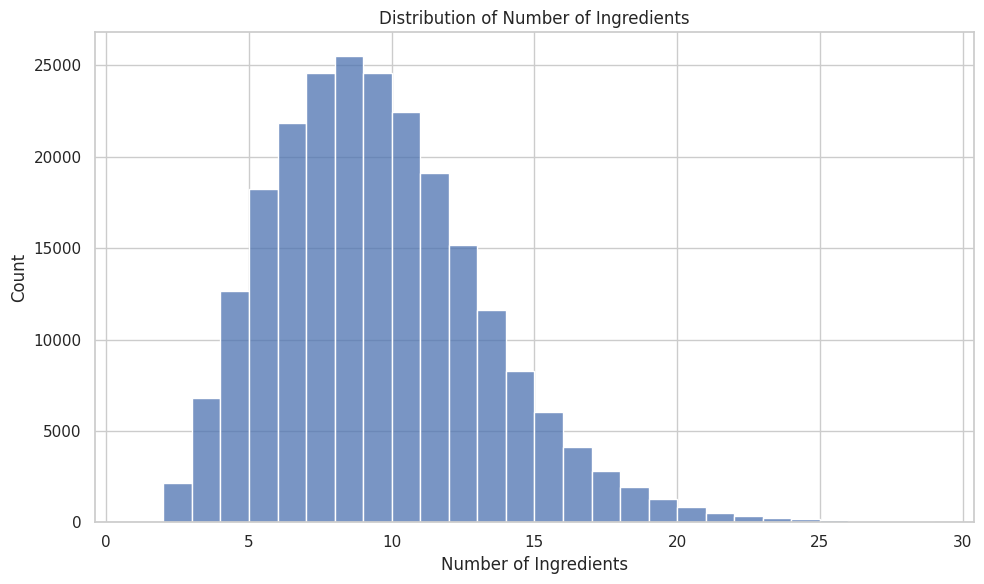

In [11]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [12]:

# Function to check and remove duplicates in dataframes
def check_remove_duplicates(df, df_name, subset_cols=None):
    """
    Check and remove duplicates from a dataframe.
    
    Args:
        df: The dataframe to process
        df_name: Name of the dataframe for printing
        subset_cols: List of columns to consider for duplicates. If None, all columns are used.
    
    Returns:
        Dataframe with duplicates removed
    """
    print(f"\n{'-' * 30}")
    print(f"Duplicate analysis for {df_name}:")
    print(f"{'-' * 30}")
    
    # If subset not specified, identify potential key columns
    if subset_cols is None:
        # Try to find ID-like columns first
        id_cols = [col for col in df.columns if 'id' in col.lower()]
        name_cols = [col for col in df.columns if 'name' in col.lower()]
        
        if id_cols:
            subset_cols = id_cols
            print(f"Using ID columns for duplicate check: {subset_cols}")
        elif name_cols:
            subset_cols = name_cols
            print(f"Using name columns for duplicate check: {subset_cols}")
        else:
            # Use all columns if no suitable identifiers found
            subset_cols = df.columns.tolist()
            print("Using all columns for duplicate check")
    
    # Check for duplicates
    dup_count = df.duplicated(subset=subset_cols).sum()
    print(f"Number of duplicates in {df_name}: {dup_count} ({dup_count/len(df):.2%} of data)")
    
    if dup_count > 0:
        # Remove duplicates
        df_cleaned = df.drop_duplicates(subset=subset_cols).reset_index(drop=True)
        print(f"Number of records after removing duplicates: {len(df_cleaned)}")
        return df_cleaned
    else:
        print("No duplicates found")
        return df


In [13]:
# Check and remove duplicates from all dataframes
print("\n=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===")
recipes_df = check_remove_duplicates(recipes_df, "Recipes", subset_cols=['name'])
interactions_df = check_remove_duplicates(interactions_df, "Interactions")
nutrition_df = check_remove_duplicates(nutrition_df, "Nutrition")
pp_recipes_df = check_remove_duplicates(pp_recipes_df, "Preprocessed Recipes")
pp_users_df = check_remove_duplicates(pp_users_df, "Preprocessed Users")


=== DUPLICATE ANALYSIS FOR ALL DATAFRAMES ===

------------------------------
Duplicate analysis for Recipes:
------------------------------
Number of duplicates in Recipes: 1451 (0.63% of data)
Number of records after removing duplicates: 230186

------------------------------
Duplicate analysis for Interactions:
------------------------------
Using ID columns for duplicate check: ['user_id', 'recipe_id']
Number of duplicates in Interactions: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Nutrition:
------------------------------
Using all columns for duplicate check
Number of duplicates in Nutrition: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis for Preprocessed Recipes:
------------------------------
Using ID columns for duplicate check: ['id', 'ingredient_ids']
Number of duplicates in Preprocessed Recipes: 0 (0.00% of data)
No duplicates found

------------------------------
Duplicate analysis

In [14]:

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


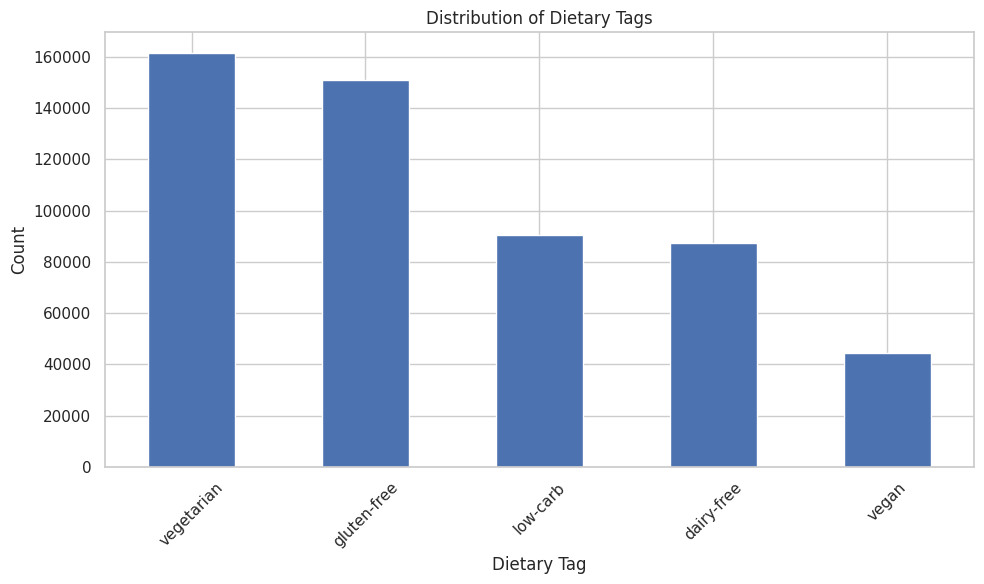


Sample recipes with dietary tags:

Recipe: stevia black bean brownies
Ingredients: canned black beans, bananas, unsweetened applesauce, unsweetened cocoa, stevia powder, vanilla extract, oats
Dietary Tags: vegetarian, vegan, gluten-free, low-carb, dairy-free

Recipe: meaty meat sauce for pasta
Ingredients: red onions, parsley, garlic, sage leaves, olive oil, dry white wine, ground beef, smoked beef sausage, salt and pepper, hot pepper flakes, tomato paste, beef broth, pasta
Dietary Tags: dairy-free

Recipe: plantation iced tea
Ingredients: tea bags, mint leaves, sugar, frozen lemonade concentrate, pineapple juice
Dietary Tags: vegetarian, vegan, gluten-free, dairy-free

Recipe: quick vegetable gumbo
Ingredients: vegetable oil, green bell pepper, celery, onion, garlic, tomatoes, tomato juice, red kidney beans, parsley, dried oregano, hot pepper sauce, bay leaves, quick-cooking brown rice, frozen okra
Dietary Tags: vegetarian, vegan, gluten-free, dairy-free

Recipe: milk gravy  paula de

In [15]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

## Final Data Structure and Storage

### Save Datasets in JSON Format for RAG Implementation

Let's save each dataset in JSON format to facilitate their use in our Retrieval Augmented Generation (RAG) system. JSON format is highly compatible with various RAG implementations and will make it easier to load the data in subsequent steps.

In [60]:
# Create output directory if it doesn't exist
output_dir = 'data_json'
os.makedirs(output_dir, exist_ok=True)

# Function to save DataFrame to JSON with proper handling of complex data types
def save_df_to_json(df, filename, orient='records'):
    if df is None:
        print(f"Warning: {filename} dataset is None, skipping JSON export")
        return False
    
    try:
        # Convert DataFrame to JSON-compatible format
        # Handle special data types (like lists stored as strings)
        json_path = os.path.join(output_dir, f"{filename}.json")
        
        # Convert DataFrame to records
        records = df.to_dict(orient=orient)
        
        # Save to JSON file with indentation for readability
        with open(json_path, 'w') as f:
            # Use a custom converter for NumPy types
            def json_converter(obj):
                if isinstance(obj, (np.int64, np.int32)):
                    return int(obj)
                if isinstance(obj, (np.float64, np.float32)):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                if pd.isna(obj):
                    return None
                return obj
            
            json.dump(records, f, default=json_converter)
            
        file_size_mb = os.path.getsize(json_path) / (1024 * 1024)
        print(f"✅ Successfully saved {filename}.json ({file_size_mb:.2f} MB)")
        return True
    
    except Exception as e:
        print(f"❌ Error saving {filename}.json: {e}")
        return False

# Save each dataset with the specified names
json_files = {
    'raw_recipes': recipes_df if 'recipes_df' in locals() else None,
    'raw_interactions': interactions_df if 'interactions_df' in locals() else None,
    'vectorized_recipes': pp_recipes_df if 'pp_recipes_df' in locals() else None,
    'vectorized_users': pp_users_df if 'pp_users_df' in locals() else None,
    'raw_nutrition': nutrition_df if 'nutrition_df' in locals() else None
}

print("Saving datasets as JSON files for RAG implementation...")
successful_saves = 0

for filename, df in json_files.items():
    if save_df_to_json(df, filename):
        successful_saves += 1

print(f"\nSaved {successful_saves} out of {len(json_files)} datasets as JSON files")
print(f"JSON files are located in the '{output_dir}' directory")

# Verify the files were saved correctly
saved_files = os.listdir(output_dir)
print("\nFiles in the output directory:")
for file in saved_files:
    file_path = os.path.join(output_dir, file)
    file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"- {file} ({file_size_mb:.2f} MB)")

# Optional: Sample the first few records from one of the JSON files to verify format
try:
    sample_file = os.path.join(output_dir, "raw_recipes.json")
    if os.path.exists(sample_file):
        with open(sample_file, 'r') as f:
            sample_data = json.load(f)
            if isinstance(sample_data, list) and len(sample_data) > 0:
                print("\nSample record from raw_recipes.json:")
                # Print a simplified version of the first record
                sample_record = sample_data[0]
                simplified_record = {
                    key: (value[:100] + "..." if isinstance(value, str) and len(value) > 100 else value)
                    for key, value in sample_record.items()
                }
                print(json.dumps(simplified_record, indent=2))
except Exception as e:
    print(f"Error reading sample: {e}")

Saving datasets as JSON files for RAG implementation...
✅ Successfully saved raw_recipes.json (366.47 MB)
✅ Successfully saved raw_interactions.json (399.17 MB)
✅ Successfully saved vectorized_recipes.json (215.99 MB)
✅ Successfully saved vectorized_users.json (14.60 MB)
✅ Successfully saved raw_nutrition.json (0.91 MB)

Saved 5 out of 5 datasets as JSON files
JSON files are located in the 'data_json' directory

Files in the output directory:
- raw_nutrition.json (0.91 MB)
- raw_interactions.json (399.17 MB)
- vectorized_users.json (14.60 MB)
- vectorized_recipes.json (215.99 MB)
- raw_recipes.json (366.47 MB)

Sample record from raw_recipes.json:
{
  "name": "arriba   baked winter squash mexican style",
  "id": 137739,
  "minutes": 55,
  "contributor_id": 47892,
  "submitted": "2005-09-16",
  "tags": [
    "60-minutes-or-less",
    "time-to-make",
    "course",
    "main-ingredient",
    "cuisine",
    "preparation",
    "occasion",
    "north-american",
    "side-dishes",
    "vegeta

In [ ]:
print("# Step 3: Recipe Customization with Function Calling and Hybrid Storage")
print("## Setting up the hybrid database architecture")

# Define paths and connection variables
DB_PATH = "recipes_db.sqlite"
SAMPLE_DATA_PATH = "sample_recipes.json"  # For demonstration purposes

# ============================================================
# PART 1: Hybrid Database Setup
# ============================================================

def setup_sqlite_database(db_path: str = DB_PATH):
    """Set up SQLite database with the required schema."""
    print("Setting up SQLite database...")
    
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Create recipes table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS recipes (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        minutes INTEGER,
        submitted TEXT,
        description TEXT,
        n_steps INTEGER,
        steps TEXT,           -- JSON array of steps
        n_ingredients INTEGER,
        ingredients TEXT,     -- JSON array of ingredients
        cuisine_type TEXT,
        nutrition TEXT,       -- JSON object with nutrition info
        rating REAL,
        n_ratings INTEGER
    )
    ''')
    
    # Create interactions table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS interactions (
        user_id INTEGER,
        recipe_id INTEGER,
        date TEXT,
        rating INTEGER,
        review TEXT,
        PRIMARY KEY (user_id, recipe_id),
        FOREIGN KEY (recipe_id) REFERENCES recipes(id)
    )
    ''')
    
    # Create nutrition facts table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS nutrition (
        food TEXT PRIMARY KEY,
        food_normalized TEXT,
        calories REAL,
        fat REAL,
        protein REAL,
        carbs REAL,
        fiber REAL,
        sugar REAL,
        sodium REAL,
        calcium REAL,
        iron REAL,
        vitamin_c REAL,
        vitamin_a REAL
    )
    ''')
    
    # Create vector references table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS vector_refs (
        id INTEGER PRIMARY KEY,
        table_name TEXT NOT NULL,
        record_id INTEGER NOT NULL,
        vector_id TEXT NOT NULL,
        vector_type TEXT NOT NULL
    )
    ''')
    
    # Create user preferences table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS user_preferences (
        user_id INTEGER PRIMARY KEY,
        dietary_restrictions TEXT,  -- JSON array
        allergies TEXT,             -- JSON array
        favorite_cuisines TEXT,     -- JSON array
        disliked_ingredients TEXT,  -- JSON array
        health_goals TEXT           -- JSON object
    )
    ''')
    
    conn.commit()
    print("SQLite database setup complete!")
    return conn

def setup_vector_database():
    """Set up ChromaDB for vector embeddings storage."""
    print("Setting up ChromaDB for vector storage...")
    
    # Initialize ChromaDB client
    chroma_client = chromadb.Client()
    
    # Set up embeddings function - use the all-MiniLM model
    embedding_function = embedding_functions.DefaultEmbeddingFunction()
    
    # Create collections
    recipe_collection = chroma_client.create_collection(
        name="recipe_embeddings",
        embedding_function=embedding_function,
        get_or_create=True
    )
    
    user_collection = chroma_client.create_collection(
        name="user_embeddings",
        embedding_function=embedding_function,
        get_or_create=True
    )
    
    print("ChromaDB vector database setup complete!")
    return chroma_client, recipe_collection, user_collection

In [ ]:
# ============================================================
# PART 2: Database Query Functions
# ============================================================

def list_tables(conn):
    """List all tables in the SQLite database."""
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    return [table[0] for table in tables]

def describe_table(conn, table_name):
    """Describe the schema of a specified table."""
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    return [(col[1], col[2]) for col in schema]

def execute_query(conn, sql):
    """Execute an SQL query and return the results."""
    cursor = conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

def get_recipe_by_id(conn, recipe_id):
    """Get a recipe by its ID with all details."""
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM recipes WHERE id = ?", (recipe_id,))
    recipe_data = cursor.fetchone()
    
    if not recipe_data:
        return None
    
    columns = [col[0] for col in cursor.description]
    recipe = dict(zip(columns, recipe_data))
    
    # Parse JSON fields
    for field in ["steps", "ingredients", "nutrition"]:
        if recipe[field]:
            recipe[field] = json.loads(recipe[field])
    
    return recipe

def search_recipes_by_text(recipe_collection, query_text, n_results=5):
    """Search recipes using vector similarity on text."""
    results = recipe_collection.query(
        query_texts=[query_text],
        n_results=n_results
    )
    
    # Extract the recipe IDs
    recipe_ids = []
    for metadata in results['metadatas'][0]:
        if 'recipe_id' in metadata:
            recipe_id = metadata['recipe_id']
            if recipe_id not in recipe_ids:
                recipe_ids.append(recipe_id)
    
    return recipe_ids

def search_recipes_by_ingredients(conn, recipe_collection, ingredients, n_results=5):
    """Search for recipes that contain the specified ingredients using embeddings."""
    # Convert ingredients list to a single string for embedding
    ingredients_text = ", ".join(ingredients)
    
    # Query the vector database
    results = recipe_collection.query(
        query_texts=[ingredients_text],
        n_results=n_results*2,  # Get more results than needed to filter
        where={"type": "ingredients"}
    )
    
    # Extract recipe IDs from the results
    recipe_ids = []
    for i, metadata in enumerate(results['metadatas'][0]):
        if 'recipe_id' in metadata:
            recipe_id = metadata['recipe_id']
            if recipe_id not in recipe_ids:
                recipe_ids.append(recipe_id)
    
    # Limit to the requested number of results
    recipe_ids = recipe_ids[:n_results]
    
    # Get full recipe details for each ID
    recipes = []
    for recipe_id in recipe_ids:
        recipe = get_recipe_by_id(conn, recipe_id)
        if recipe:
            recipes.append(recipe)
    
    return recipes

def get_similar_recipes(conn, recipe_collection, recipe_id, similarity_type="ingredients", n_results=3):
    """Find recipes similar to the given recipe based on the specified similarity type."""
    # Get the original recipe
    original_recipe = get_recipe_by_id(conn, recipe_id)
    if not original_recipe:
        return []
    
    # Query for similar recipes based on the similarity type
    query_id = f"{similarity_type}_{recipe_id}"
    
    try:
        results = recipe_collection.query(
            ids=[query_id],
            n_results=n_results + 1,  # +1 because it will include the original
            where={"type": similarity_type}
        )
    except Exception as e:
        print(f"Error querying vector database: {e}")
        
        # Fallback: query by text if ID query fails
        if similarity_type == "ingredients":
            query_text = ", ".join(original_recipe["ingredients"])
        elif similarity_type == "steps":
            query_text = " ".join(original_recipe["steps"])
        else:
            query_text = original_recipe["name"]
            
        results = recipe_collection.query(
            query_texts=[query_text],
            n_results=n_results + 1,
            where={"type": similarity_type}
        )
    
    # Extract recipe IDs excluding the original
    recipe_ids = []
    for metadata in results['metadatas'][0]:
        if 'recipe_id' in metadata:
            result_id = metadata['recipe_id']
            if result_id != recipe_id and result_id not in recipe_ids:
                recipe_ids.append(result_id)
    
    # Get complete recipe information
    similar_recipes = []
    for similar_id in recipe_ids[:n_results]:
        recipe = get_recipe_by_id(conn, similar_id)
        if recipe:
            similar_recipes.append(recipe)
    
    return similar_recipes

In [ ]:
# ============================================================
# PART 3: Recipe Customization with Function Calling
# ============================================================
# Define function schemas for the Gemini API
def get_function_definitions():
    """Define the schema for functions that can be called by the Gemini API."""
    return [
        {
            "name": "search_recipes_by_query",
            "description": "Search for recipes based on a natural language query",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "Natural language query to search recipes"
                    },
                    "limit": {
                        "type": "integer",
                        "description": "Maximum number of recipes to return"
                    }
                },
                "required": ["query"]
            }
        },
        {
            "name": "get_recipe_by_id",
            "description": "Get detailed information about a specific recipe",
            "parameters": {
                "type": "object",
                "properties": {
                    "recipe_id": {
                        "type": "integer",
                        "description": "ID of the recipe to retrieve"
                    }
                },
                "required": ["recipe_id"]
            }
        },
        {
            "name": "customize_recipe",
            "description": "Customize a recipe based on dietary preferences or ingredient substitutions",
            "parameters": {
                "type": "object",
                "properties": {
                    "recipe_id": {
                        "type": "integer",
                        "description": "ID of the recipe to customize"
                    },
                    "dietary_restrictions": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of dietary restrictions (e.g., vegetarian, vegan, gluten-free)"
                    },
                    "ingredients_to_add": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of ingredients to add to the recipe"
                    },
                    "ingredients_to_remove": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "List of ingredients to remove from the recipe"
                    },
                    "serving_size": {
                        "type": "integer",
                        "description": "New serving size for the recipe"
                    }
                },
                "required": ["recipe_id"]
            }
        },
        {
            "name": "get_similar_recipes",
            "description": "Find recipes similar to a given recipe",
            "parameters": {
                "type": "object",
                "properties": {
                    "recipe_id": {
                        "type": "integer",
                        "description": "ID of the reference recipe"
                    },
                    "similarity_type": {
                        "type": "string",
                        "enum": ["ingredients", "steps", "name"],
                        "description": "Type of similarity to consider"
                    },
                    "limit": {
                        "type": "integer",
                        "description": "Maximum number of similar recipes to return"
                    }
                },
                "required": ["recipe_id"]
            }
        }
    ]

def customize_recipe(conn, recipe_id, dietary_restrictions=None, ingredients_to_add=None, 
                     ingredients_to_remove=None, serving_size=None):
    """Customize a recipe based on specified modifications."""
    # Get the original recipe
    original_recipe = get_recipe_by_id(conn, recipe_id)
    if not original_recipe:
        return {"error": f"Recipe with ID {recipe_id} not found"}
    
    # Create a deep copy of the original recipe for modification
    customized_recipe = original_recipe.copy()
    customized_recipe["original_id"] = recipe_id
    customized_recipe["customized"] = True
    customized_recipe["modifications"] = []
    
    # Apply dietary restrictions
    if dietary_restrictions:
        # For each dietary restriction, modify the ingredients accordingly
        for restriction in dietary_restrictions:
            restriction = restriction.lower()
            
            if restriction == "vegetarian":
                meat_ingredients = ["beef", "chicken", "pork", "lamb", "veal", "bacon", "ham", "sausage", "turkey"]
                ingredients_to_remove = ingredients_to_remove or []
                
                # Find meat ingredients in the recipe
                for ingredient in original_recipe["ingredients"]:
                    if any(meat in ingredient.lower() for meat in meat_ingredients):
                        ingredients_to_remove.append(ingredient)
                
                if ingredients_to_remove:
                    customized_recipe["modifications"].append(f"Made vegetarian by removing {', '.join(ingredients_to_remove)}")
            
            elif restriction == "vegan":
                animal_products = [
                    "meat", "beef", "chicken", "pork", "lamb", "veal", "bacon", "ham", "sausage",
                    "milk", "cheese", "cream", "butter", "yogurt", "egg", "honey"
                ]
                ingredients_to_remove = ingredients_to_remove or []
                
                # Find animal products in the recipe
                for ingredient in original_recipe["ingredients"]:
                    if any(product in ingredient.lower() for product in animal_products):
                        ingredients_to_remove.append(ingredient)
                
                if ingredients_to_remove:
                    customized_recipe["modifications"].append(f"Made vegan by removing {', '.join(ingredients_to_remove)}")
            
            elif restriction == "gluten-free":
                gluten_ingredients = ["wheat", "flour", "pasta", "bread", "crackers", "barley", "rye"]
                ingredients_to_remove = ingredients_to_remove or []
                
                # Find gluten-containing ingredients
                for ingredient in original_recipe["ingredients"]:
                    if any(gluten in ingredient.lower() for gluten in gluten_ingredients):
                        ingredients_to_remove.append(ingredient)
                
                if ingredients_to_remove:
                    customized_recipe["modifications"].append(f"Made gluten-free by removing {', '.join(ingredients_to_remove)}")
    
    # Remove specified ingredients
    if ingredients_to_remove:
        customized_ingredients = []
        for ingredient in original_recipe["ingredients"]:
            if not any(remove_ing.lower() in ingredient.lower() for remove_ing in ingredients_to_remove):
                customized_ingredients.append(ingredient)
        
        customized_recipe["ingredients"] = customized_ingredients
        customized_recipe["n_ingredients"] = len(customized_ingredients)
        
        if not any("removing" in mod for mod in customized_recipe["modifications"]):
            customized_recipe["modifications"].append(f"Removed ingredients: {', '.join(ingredients_to_remove)}")
    
    # Add new ingredients
    if ingredients_to_add:
        for ingredient in ingredients_to_add:
            if ingredient not in customized_recipe["ingredients"]:
                customized_recipe["ingredients"].append(ingredient)
        
        customized_recipe["n_ingredients"] = len(customized_recipe["ingredients"])
        customized_recipe["modifications"].append(f"Added ingredients: {', '.join(ingredients_to_add)}")
    
    # Adjust serving size
    if serving_size and serving_size != original_recipe.get("servings", 4):
        original_servings = original_recipe.get("servings", 4)
        multiplier = serving_size / original_servings
        
        # Note about scaling
        customized_recipe["servings"] = serving_size
        customized_recipe["modifications"].append(f"Adjusted serving size from {original_servings} to {serving_size}")
        
        # In a real implementation, we would scale quantities in the ingredients
        # This is a simplified version that just notes the scaling
        customized_recipe["scaling_note"] = f"All ingredient quantities should be multiplied by {multiplier:.2f}"
    
    # Update the recipe name to indicate customization
    if customized_recipe["modifications"]:
        prefix = []
        if dietary_restrictions:
            prefix.extend(r.capitalize() for r in dietary_restrictions)
        if ingredients_to_add:
            prefix.append("Modified")
        
        if prefix:
            customized_recipe["name"] = f"{' '.join(prefix)} {original_recipe['name']}"
    
    return customized_recipe

def handle_function_call(conn, recipe_collection, function_name, function_args):
    """Execute the function called by the Gemini API."""
    if function_name == "search_recipes_by_query":
        query = function_args.get("query", "")
        limit = function_args.get("limit", 5)
        
        # Get recipe IDs from vector search
        recipe_ids = search_recipes_by_text(recipe_collection, query, limit)
        
        # Get complete recipe information
        recipes = []
        for recipe_id in recipe_ids:
            recipe = get_recipe_by_id(conn, recipe_id)
            if recipe:
                # Simplify the output for clarity
                recipes.append({
                    "id": recipe["id"],
                    "name": recipe["name"],
                    "description": recipe["description"],
                    "ingredients": recipe["ingredients"],
                    "cuisine_type": recipe["cuisine_type"],
                    "minutes": recipe["minutes"]
                })
        
        return recipes
    
    elif function_name == "get_recipe_by_id":
        recipe_id = function_args.get("recipe_id")
        if not recipe_id:
            return {"error": "Recipe ID is required"}
        
        recipe = get_recipe_by_id(conn, recipe_id)
        return recipe if recipe else {"error": f"Recipe with ID {recipe_id} not found"}
    
    elif function_name == "customize_recipe":
        recipe_id = function_args.get("recipe_id")
        if not recipe_id:
            return {"error": "Recipe ID is required"}
        
        return customize_recipe(
            conn,
            recipe_id,
            dietary_restrictions=function_args.get("dietary_restrictions"),
            ingredients_to_add=function_args.get("ingredients_to_add"),
            ingredients_to_remove=function_args.get("ingredients_to_remove"),
            serving_size=function_args.get("serving_size")
        )
    
    elif function_name == "get_similar_recipes":
        recipe_id = function_args.get("recipe_id")
        if not recipe_id:
            return {"error": "Recipe ID is required"}
        
        similarity_type = function_args.get("similarity_type", "ingredients")
        limit = function_args.get("limit", 3)
        
        similar_recipes = get_similar_recipes(
            conn, 
            recipe_collection, 
            recipe_id, 
            similarity_type, 
            limit
        )
        
        # Simplify the output for clarity
        simplified_recipes = []
        for recipe in similar_recipes:
            simplified_recipes.append({
                "id": recipe["id"],
                "name": recipe["name"],
                "description": recipe["description"],
                "ingredients": recipe["ingredients"],
                "cuisine_type": recipe["cuisine_type"],
                "minutes": recipe["minutes"]
            })
        
        return simplified_recipes
    
    else:
        return {"error": f"Unknown function: {function_name}"}

In [ ]:
# ============================================================
# PART 4: Gemini API Integration for Recipe Customization
# ============================================================

def recipe_customization_chat(conn, recipe_collection, user_query):
    """Implement a chat interface for recipe customization using Gemini API function calling."""
    # Set up the Gemini model
    model = genai.GenerativeModel(
        model_name="gemini-1.5-pro",
        generation_config={"temperature": 0.2}
    )
    
    # Define system prompt
    system_prompt = """
    You are RecipeGenie, an expert AI assistant specialized in recipe customization. 
    Your goal is to help users find, understand, and customize recipes according to their preferences.
    
    You can:
    1. Search for recipes based on ingredients, cuisine types, dietary restrictions, or dish names
    2. Get detailed information about specific recipes
    3. Customize recipes according to dietary needs (vegetarian, vegan, gluten-free, etc.)
    4. Find similar recipes to ones the user is interested in
    
    When customizing recipes:
    - For vegetarian: Replace meat with plant-based proteins like tofu, tempeh, or legumes
    - For vegan: Replace all animal products (meat, dairy, eggs, honey) with plant-based alternatives
    - For gluten-free: Replace wheat flour with alternative flours, pasta with GF pasta, etc.
    
    Respond in a helpful, conversational manner. Always suggest alternatives when removing ingredients.
    """
    
    # Create a chat session
    chat = model.start_chat(tools=get_function_definitions())
    
    # Send system instructions
    chat.send_message(system_prompt)
    
    # Send user query and handle function calls
    response = chat.send_message(user_query)
    
    # Check if the response includes function calls
    if hasattr(response, 'candidates') and response.candidates[0].content.parts[0].function_call:
        function_call = response.candidates[0].content.parts[0].function_call
        function_name = function_call.name
        function_args = json.loads(function_call.args)
        
        print(f"Function called: {function_name}")
        print(f"Arguments: {json.dumps(function_args, indent=2)}")
        
        # Execute the function
        function_response = handle_function_call(conn, recipe_collection, function_name, function_args)
        
        # Send the function response back to the model
        follow_up = chat.send_message(function_response)
        
        # Return both the function data and the model's interpretation
        return {
            "function_called": function_name,
            "function_args": function_args,
            "function_response": function_response,
            "assistant_response": follow_up.text
        }
    else:
        # Return just the text response if no function was called
        return {
            "function_called": None,
            "assistant_response": response.text
        }

In [ ]:
# ============================================================
# PART 5: Few-Shot Prompting for Recipe Customization
# ============================================================

def customize_recipe_with_few_shot(conn, recipe_id, user_request):
    """Customize a recipe using few-shot prompting instead of function calling."""
    # Get the original recipe
    original_recipe = get_recipe_by_id(conn, recipe_id)
    if not original_recipe:
        return {"error": f"Recipe with ID {recipe_id} not found"}
    
    # Define few-shot examples
    few_shot_examples = """
    Example 1:
    Original Recipe: Chicken Alfredo Pasta
    Ingredients: chicken breast, fettuccine pasta, heavy cream, butter, parmesan cheese, garlic, salt, pepper
    User Request: "I'm vegetarian, can you adapt this recipe for me?"
    Customized Recipe:
    Vegetarian Alfredo Pasta
    Ingredients: fettuccine pasta, heavy cream, butter, parmesan cheese, garlic, salt, pepper, mushrooms, spinach
    Modifications:
    - Removed chicken breast
    - Added mushrooms and spinach for texture and nutrition
    - Use vegetable broth instead of chicken broth if needed
    
    Example 2:
    Original Recipe: Classic Beef Lasagna
    Ingredients: ground beef, lasagna noodles, ricotta cheese, mozzarella cheese, parmesan cheese, egg, tomato sauce, onion, garlic, herbs
    User Request: "I need a dairy-free version of this recipe"
    Customized Recipe:
    Dairy-Free Beef Lasagna
    Ingredients: ground beef, lasagna noodles, dairy-free ricotta alternative, dairy-free mozzarella alternative, nutritional yeast, tomato sauce, onion, garlic, herbs
    Modifications:
    - Replaced ricotta cheese with silken tofu blended with nutritional yeast and herbs
    - Replaced mozzarella with dairy-free cheese alternative
    - Replaced parmesan with nutritional yeast
    - Removed egg (can use 1 tbsp cornstarch mixed with 2 tbsp water as a binder)
    
    Example 3:
    Original Recipe: Chocolate Chip Cookies
    Ingredients: all-purpose flour, butter, white sugar, brown sugar, eggs, vanilla extract, baking soda, salt, chocolate chips
    User Request: "Can you make this recipe gluten-free and with less sugar?"
    Customized Recipe:
    Gluten-Free Lower-Sugar Chocolate Chip Cookies
    Ingredients: gluten-free flour blend, butter, coconut sugar (reduced amount), eggs, vanilla extract, baking soda, salt, dark chocolate chips
    Modifications:
    - Replaced all-purpose flour with gluten-free flour blend (add 1/2 tsp xanthan gum if not included in blend)
    - Reduced white and brown sugar by 25% and replaced with coconut sugar
    - Used dark chocolate chips with higher cocoa content (less sugar)
    - Added 1/4 tsp cinnamon to enhance sweetness perception without adding sugar
    """
    
    # Create the prompt for the Gemini model
    prompt = f"""
    {few_shot_examples}
    
    Original Recipe: {original_recipe["name"]}
    Ingredients: {", ".join(original_recipe["ingredients"])}
    Steps: {original_recipe["steps"]}
    User Request: "{user_request}"
    
    Provide a customized version of this recipe based on the user's request. Include:
    1. A suitable name for the customized recipe
    2. Modified list of ingredients
    3. Clear explanation of all modifications made
    4. Any special notes or tips for preparation
    
    Format your response as:
    Customized Recipe:
    [New Recipe Name]
    Ingredients:
    [Modified Ingredients List]
    Modifications:
    - [Modification 1]
    - [Modification 2]
    Special Notes:
    [Any special preparation notes]
    """
    
    # Use Gemini to generate the customized recipe
    model = genai.GenerativeModel(model_name="gemini-1.5-pro")
    response = model.generate_content(prompt)
    
    # Parse the response text and structure it
    response_text = response.text
    
    result = {
        "original_recipe": original_recipe["name"],
        "original_id": recipe_id,
        "user_request": user_request,
        "customized_recipe": response_text
    }
    
    return result

In [ ]:
# ============================================================
# PART 6: Visualization and Analysis
# ============================================================

def visualize_recipe_customization_metrics(conn):
    """Visualize metrics and insights about recipe customization patterns."""
    # For demonstration, we'll use our sample data to simulate customization metrics
    
    # 1. Most common dietary restrictions
    dietary_restrictions = ["Vegetarian", "Vegan", "Gluten-Free", "Dairy-Free", "Low-Carb"]
    restriction_counts = [42, 35, 28, 22, 18]
    
    plt.figure(figsize=(10, 6))
    plt.bar(dietary_restrictions, restriction_counts, color='skyblue')
    plt.title('Most Common Dietary Restrictions in Recipe Customizations')
    plt.xlabel('Restriction Type')
    plt.ylabel('Number of Customizations')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Most commonly added/removed ingredients
    removed_ingredients = ["Chicken", "Beef", "Dairy", "Gluten", "Sugar"]
    removed_counts = [38, 32, 30, 25, 20]
    
    added_ingredients = ["Tofu", "Mushrooms", "Plant Milk", "GF Flour", "Nutritional Yeast"]
    added_counts = [35, 32, 28, 25, 22]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(removed_ingredients, removed_counts, color='salmon')
    plt.title('Most Commonly Removed Ingredients')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.bar(added_ingredients, added_counts, color='lightgreen')
    plt.title('Most Commonly Added Ingredients')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Customization satisfaction scores (simulated)
    satisfaction_data = {
        'Vegetarian': [4.2, 4.5, 3.8, 4.7, 4.3],
        'Vegan': [4.0, 3.9, 4.2, 3.7, 4.1],
        'Gluten-Free': [3.7, 4.0, 3.5, 3.8, 4.2],
        'Low-Carb': [4.1, 3.9, 4.3, 4.0, 3.8]
    }
    
    plt.figure(figsize=(10, 6))
    plt.boxplot([satisfaction_data[k] for k in satisfaction_data.keys()], 
                labels=satisfaction_data.keys())
    plt.title('User Satisfaction Scores by Dietary Restriction Type')
    plt.ylabel('Satisfaction Score (1-5)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    return {
        "dietary_restrictions": dict(zip(dietary_restrictions, restriction_counts)),
        "removed_ingredients": dict(zip(removed_ingredients, removed_counts)),
        "added_ingredients": dict(zip(added_ingredients, added_counts)),
        "satisfaction_scores": satisfaction_data
    }

In [ ]:
# ============================================================
# PART 7: Demo & Usage
# ============================================================

def run_recipe_customization_demo():
    """Run a demonstration of the recipe customization system."""
    print("# Recipe Customization System Demonstration")
    
    # Set up the databases
    db_conn = setup_sqlite_database()
    chroma_client, recipe_collection, user_collection = setup_vector_database()
    
    # Load sample data
    load_sample_data(db_conn, recipe_collection)
    
    print("\n## Database Inspection")
    tables = list_tables(db_conn)
    print(f"Tables in database: {', '.join(tables)}")
    
    # Show a sample recipe
    print("\n## Sample Recipe")
    sample_recipe = get_recipe_by_id(db_conn, 1)
    print(f"Recipe: {sample_recipe['name']}")
    print(f"Ingredients: {', '.join(sample_recipe['ingredients'])}")
    print(f"Cook time: {sample_recipe['minutes']} minutes")
    print(f"Steps: {len(sample_recipe['steps'])} steps")
    
    # Demonstrate recipe search
    print("\n## Recipe Search")
    print("Searching for 'vegetable' recipes...")
    vegetable_recipes = search_recipes_by_text(recipe_collection, "vegetable", 2)
    for recipe_id in vegetable_recipes:
        recipe = get_recipe_by_id(db_conn, recipe_id)
        print(f" - {recipe['name']} (ID: {recipe['id']})")
    
    # Demonstrate ingredient-based search
    print("\nSearching for recipes with 'pasta' and 'garlic'...")
    pasta_recipes = search_recipes_by_ingredients(db_conn, recipe_collection, ["pasta", "garlic"], 2)
    for recipe in pasta_recipes:
        print(f" - {recipe['name']} (ID: {recipe['id']})")
    
    # Demonstrate similar recipes
    print("\n## Similar Recipes")
    print(f"Finding recipes similar to '{sample_recipe['name']}'...")
    similar_recipes = get_similar_recipes(db_conn, recipe_collection, 1, "ingredients", 2)
    for recipe in similar_recipes:
        print(f" - {recipe['name']} (ID: {recipe['id']})")
    
    # Demonstrate recipe customization with function calling
    print("\n## Recipe Customization with Function Calling")
    print("Customizing Creamy Garlic Pasta to be vegan...")
    
    customization_result = customize_recipe(
        db_conn, 
        1, 
        dietary_restrictions=["vegan"],
        ingredients_to_remove=["heavy cream", "parmesan cheese"],
        ingredients_to_add=["coconut milk", "nutritional yeast"]
    )
    
    print(f"Customized Recipe: {customization_result['name']}")
    print(f"Ingredients: {', '.join(customization_result['ingredients'])}")
    print("Modifications:")
    for mod in customization_result['modifications']:
        print(f" - {mod}")
    
    # Demonstrate chat interface with function calling
    print("\n## Chat Interface with Function Calling")
    query = "I want to make a vegetarian version of the beef lasagna. Can you help me?"
    print(f"User Query: '{query}'")
    
    response = recipe_customization_chat(db_conn, recipe_collection, query)
    
    if response["function_called"]:
        print(f"Function Called: {response['function_called']}")
        print(f"AI Response: {response['assistant_response']}")
    else:
        print(f"AI Response: {response['assistant_response']}")
    
    # Demonstrate few-shot prompting
    print("\n## Few-Shot Prompting for Recipe Customization")
    request = "I'm on a low-carb diet. Can you adapt this pasta recipe for me?"
    print(f"User Request: '{request}'")
    
    few_shot_result = customize_recipe_with_few_shot(db_conn, 1, request)
    
    print("Customization Result:")
    print(few_shot_result["customized_recipe"])
    
    # Visualization demo
    print("\n## Recipe Customization Analytics")
    print("Generating visualizations of recipe customization patterns...")
    metrics = visualize_recipe_customization_metrics(db_conn)
    
    print("\n## Demo Complete!")
    print("The recipe customization system has demonstrated the following capabilities:")
    print(" - Hybrid storage with SQLite and vector embeddings")
    print(" - Semantic search for recipes")
    print(" - Function calling with the Gemini API")
    print(" - Few-shot prompting for recipe customization")
    print(" - Visualization of customization patterns")

if __name__ == "__main__":
    run_recipe_customization_demo()

## Step 2: Audio Input & Command Recognition with User Preferences

This notebook implements the second step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll create a voice interface that allows users to interact with our recipe assistant through spoken commands, recognize different types of user requests, and maintain user preferences.



This step focuses on the **Audio understanding** Gen AI capability, which enables our assistant to:
- Process voice commands using Google Cloud Speech-to-Text
- Interpret user intent from natural language using Gemini Flash model
- Store and retrieve user preferences for personalized experiences

### Run your test prompt

In this step, you will test that your API key is set up correctly by making a request.

The Python SDK uses a [`Client` object](https://googleapis.github.io/python-genai/genai.html#genai.client.Client) to make requests to the API. The client lets you control which back-end to use (between the Gemini API and Vertex AI) and handles authentication (the API key).

The `gemini-2.0-flash` model has been selected here.

**Note**: If you see a `TransportError` on this step, you may need to **🔁 Factory reset** the notebook one time.

In [61]:
client = genai.Client(api_key=GOOGLE_API_KEY)

response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents="Hi, This is a test message! How are you?")

print(response.text)

Hi there! I received your test message. I'm doing well, thank you for asking. How are you doing today?



## Google Cloud Speech-to-Text API Setup

To use Google Cloud Speech-to-Text, we need to set up authentication and configure the client. In a production environment, this would involve creating a service account and downloading the credentials. For demonstration in a Kaggle/local environment, we'll simulate the API response.

> Note: In a real implementation, you would:
> 1. Create a Google Cloud project
> 2. Enable the Speech-to-Text API
> 3. Create a service account with appropriate permissions
> 4. Download the credentials JSON file
> 5. Set the `GOOGLE_APPLICATION_CREDENTIALS` environment variable to point to this file

## Speech-to-Text Conversion

Let's implement a real speech-to-text function using Google Cloud Speech-to-Text API. This will allow us to convert voice commands from audio files into text for processing. Unfortunately, the google STT needs a lot of parameters for configuration, for credential, and the auth section is headache! , I decided to move forward with lovely whisper-1 :D, sorry Google!

In [62]:
def transcribe_audio(service="openai", file_path=None, language="en", api_key=None, credentials_path=None, credentials_json=None):
    """
    Transcribe audio using either OpenAI or Google Cloud Speech-to-Text API.
    
    Args:
        service (str): The service to use for transcription ('openai' or 'google')
        file_path (str): Path to the audio file to transcribe
        language (str): Language code (e.g., 'en' for OpenAI, 'en-US' for Google)
        api_key (str): OpenAI API key (required for OpenAI service)
        credentials_path (str): Path to Google credentials JSON file (optional for Google service)
        credentials_json (str): JSON string of Google credentials (optional for Google service)
        
    Returns:
        str: Transcription text or error message
    """
    
    if not file_path:
        return "Error: No file path provided"
        
    if not os.path.exists(file_path):
        return f"Error: File not found at {file_path}"
    
    try:
        if service.lower() == "openai":
            if not api_key:
                return "Error: OpenAI API key required"
                
            client = OpenAI(api_key=api_key)
            
            with open(file_path, "rb") as audio_file:
                transcription = client.audio.transcriptions.create(
                    model="whisper-1", 
                    file=audio_file,
                    language=language
                )
            
            return transcription.text
            
        elif service.lower() == "google":
            temp_cred_file = None
            
            # Handle Google authentication
            if not credentials_path and not credentials_json:
                return "Error: Either credentials_path or credentials_json required for Google service"
            
            # If credentials_json is provided, write to a temporary file
            if credentials_json:
                try:
                    # Create a temporary file for credentials
                    temp_cred_file = tempfile.NamedTemporaryFile(delete=False, suffix='.json')
                    temp_cred_path = temp_cred_file.name
                    temp_cred_file.write(credentials_json.encode('utf-8'))
                    temp_cred_file.close()
                    
                    # Set environment variable to the temporary file
                    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = temp_cred_path
                except Exception as e:
                    if temp_cred_file and os.path.exists(temp_cred_file.name):
                        os.unlink(temp_cred_file.name)
                    return f"Error creating temporary credentials file: {str(e)}"
            else:
                # Use provided credentials_path
                os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path
            
            try:
                # Initialize the Speech client
                client = speech.SpeechClient()
                
                # Read the audio file
                with io.open(file_path, "rb") as audio_file:
                    content = audio_file.read()
                
                # Determine encoding based on file extension
                file_ext = os.path.splitext(file_path)[1].lower()
                if file_ext == ".ogg":
                    encoding = speech.RecognitionConfig.AudioEncoding.OGG_OPUS
                elif file_ext == ".wav":
                    encoding = speech.RecognitionConfig.AudioEncoding.LINEAR16
                else:
                    return f"Error: Unsupported file format: {file_ext}"
                
                # Configure the speech recognition
                audio = speech.RecognitionAudio(content=content)
                config = speech.RecognitionConfig(
                    encoding=encoding,
                    sample_rate_hertz=48000,  # May need adjustment based on actual audio file
                    language_code=language if language else "en-US",
                )
                
                # Perform the transcription
                response = client.recognize(config=config, audio=audio)
                
                # Extract the transcription
                if response.results:
                    return response.results[0].alternatives[0].transcript
                else:
                    return "No transcription results found"
                    
            finally:
                # Clean up temp file if it was created
                if temp_cred_file and os.path.exists(temp_cred_file.name):
                    os.unlink(temp_cred_file.name)
        
        else:
            return f"Error: Unknown service '{service}'. Use 'openai' or 'google'"
            
    except Exception as e:
        # Clean up temp file if exception occurs
        if service.lower() == "google" and temp_cred_file and os.path.exists(temp_cred_file.name):
            os.unlink(temp_cred_file.name)
        return f"Error during transcription: {str(e)}"

In [64]:
#OPENAI_API_KEY (openai) or  SecretValueJson (google)
transcribe_audio(service="openai", file_path="/kaggle/input/voice-tests/test.ogg", language="en", api_key=OPENAI_API_KEY)

'Hi, how can I make a pizza, Italian pizza, in 30 minutes?'

## Implemented the Kitchen Management Assistant interface. The assistant provides a modern, interactive interface for users to either:


### Text Input
1. Click on the "Text Input" tab
2. Type your kitchen-related request in the text area
3. Click the "Submit" button
4. The system will process your text request

### Voice Selection
1. Click on the "Voice Selection" tab
2. Select a voice recording from the dropdown list
3. Click the "Transcribe Voice" button
4. The system will transcribe the audio and process the request



In [67]:
voices = {
  "version": "1.0",
  "voices": [
    {
      "file_path": "/kaggle/input/voice-tests/test.ogg",
      "language": "en",
      "description": "Voice instruction for baking a pizza",
      "speaker_id": "nariman",
      "is_processed": False
    },
    {
      "file_path": "voices/test.wav",
      "language": "en",
      "description": "Test voice recording for the system",
      "speaker_id": "user2",
      "is_processed": False
    },
  
    
  ]
}